## Nama : Ridopandi Sinaga

---

### Import Library

In [61]:
import os, zipfile, shutil, PIL
import numpy as np
import tensorflow as tf

from tensorflow import keras
from google.colab import files

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Menginstall Kaggle

In [39]:
!pip install -q kaggle

### Upload Kredensial (Token API)

In [42]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


### Konfigurasi untuk menerima datasets dari Kaggle

In [43]:
!chmod 600 /content/kaggle.json

### Download Dataset

kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

In [44]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d viratkothari/animal10

animal10.zip: Skipping, found more recently modified local copy (use --force to force download)


### Mengekstrak Dataset

In [24]:
local_zip = '/content/animal10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Mendeklarasikan Direktori Dasar

In [25]:
BASE_DIR = '/content/Animals-10/'

### Membuat fungsi list_files untuk mengidentifikasi jumlah file

In [26]:
def list_files(startpath):
  num_files = 0
  for root, dirs, files in os.walk(startpath):
    level = root.replace(startpath, '').count(os.sep)
    indent = ' ' * 2 * (level)
    num_files += len(files)
    print('{}{}/ {}'.format(indent, os.path.basename(root), (str(len(files)) + ' images' if len(files) > 0 else '')))

  return num_files

### Memanggil fungsi list_files dengan parameter variabel direktori dasar yang telah dibuat sebelumnya

In [27]:
list_files(BASE_DIR)

/ 
sheep/ 1820 images
dog/ 4863 images
cow/ 1866 images
spider/ 4821 images
chicken/ 3098 images
butterfly/ 2112 images
horse/ 2623 images
elephant/ 1446 images
cat/ 1668 images
squirrel/ 1862 images


26179

### Fungsi read_files untuk membaca setiap files

In [28]:
def read_files(startpath):
  image_files = []
  for dirname, dirnames, filenames in os.walk(startpath):
    for filename in filenames:
      image_files.append(os.path.join(dirname, filename))

  return image_files

### Menghapus file yang tidak digunakan

In [29]:
ignore_dir = ['sheep', 'cow', 'butterfly', 'horse', 'elephant', 'cat', 'squirrel']

for dir in ignore_dir:
  path = os.path.join(BASE_DIR, dir)
  shutil.rmtree(path)

print(os.listdir(BASE_DIR))

['dog', 'spider', 'chicken']


### Memastikan ukuran image yang beragam dengan fungsi PIL

In [32]:
full_dirs = read_files(BASE_DIR)
image_sizes = []
for file in full_dirs:
  image = PIL.Image.open(file)
  width, height = image.size
  image_sizes.append(f'{width}x{height}')

unique_sizes = set(image_sizes)

print(f'Size all images: {len(image_sizes)}')
print(f'Size unique images: {len(unique_sizes)}')
print(f'First 10 unique images: \n{list(unique_sizes)[:10]}')

Size all images: 12782
Size unique images: 638
First 10 unique images: 
['250x180', '300x285', '300x262', '219x147', '286x300', '300x238', '640x354', '208x300', '258x241', '280x210']


## **Data Preprocessing dan Data Splitting**

### Melakukan Augmentasi Gambar

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2)

## Data Image Generator

In [46]:
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='validation')

Found 10227 images belonging to 3 classes.
Found 2555 images belonging to 3 classes.


## Modelling and compile it

In [50]:
#modelling
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3))),
model.add(MaxPooling2D(2, 2)),

model.add(Conv2D(64, (3,3), activation='relu')),
model.add(MaxPooling2D(2,2)),

model.add(Conv2D(128, (3,3), activation='relu')),
model.add(MaxPooling2D(2,2)),

model.add(Conv2D(128, (3,3), activation='relu')),
model.add(MaxPooling2D(2,2)),

model.add(Flatten()),

model.add(Dense(512, activation='relu')),
model.add(Dense(3, activation='softmax')),

model.summary()

# compiling model
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)     

## Training model

In [51]:
#callback function to stop training

class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') and logs.get('val_accuracy') > 0.90):
      print("\n Horray, data training  accuracy has been rate  above 90%")
      self.model.stop_training = True

callbacks = Callback()


# Training model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[callbacks])

Epoch 1/50
80/80 - 98s - loss: 0.9502 - accuracy: 0.5304 - val_loss: 0.8399 - val_accuracy: 0.6207 - 98s/epoch - 1s/step
Epoch 2/50
80/80 - 91s - loss: 0.6937 - accuracy: 0.7068 - val_loss: 0.6428 - val_accuracy: 0.7346 - 91s/epoch - 1s/step
Epoch 3/50
80/80 - 89s - loss: 0.5675 - accuracy: 0.7724 - val_loss: 0.6227 - val_accuracy: 0.7429 - 89s/epoch - 1s/step
Epoch 4/50
80/80 - 89s - loss: 0.4757 - accuracy: 0.8109 - val_loss: 0.4377 - val_accuracy: 0.8368 - 89s/epoch - 1s/step
Epoch 5/50
80/80 - 90s - loss: 0.3871 - accuracy: 0.8520 - val_loss: 0.3914 - val_accuracy: 0.8587 - 90s/epoch - 1s/step
Epoch 6/50
80/80 - 87s - loss: 0.3573 - accuracy: 0.8660 - val_loss: 0.3784 - val_accuracy: 0.8568 - 87s/epoch - 1s/step
Epoch 7/50
80/80 - 89s - loss: 0.3449 - accuracy: 0.8695 - val_loss: 0.3817 - val_accuracy: 0.8568 - 89s/epoch - 1s/step
Epoch 8/50
80/80 - 89s - loss: 0.3073 - accuracy: 0.8830 - val_loss: 0.3915 - val_accuracy: 0.8591 - 89s/epoch - 1s/step
Epoch 9/50
80/80 - 91s - loss: 0

## **Plot Accuracy & Loss**

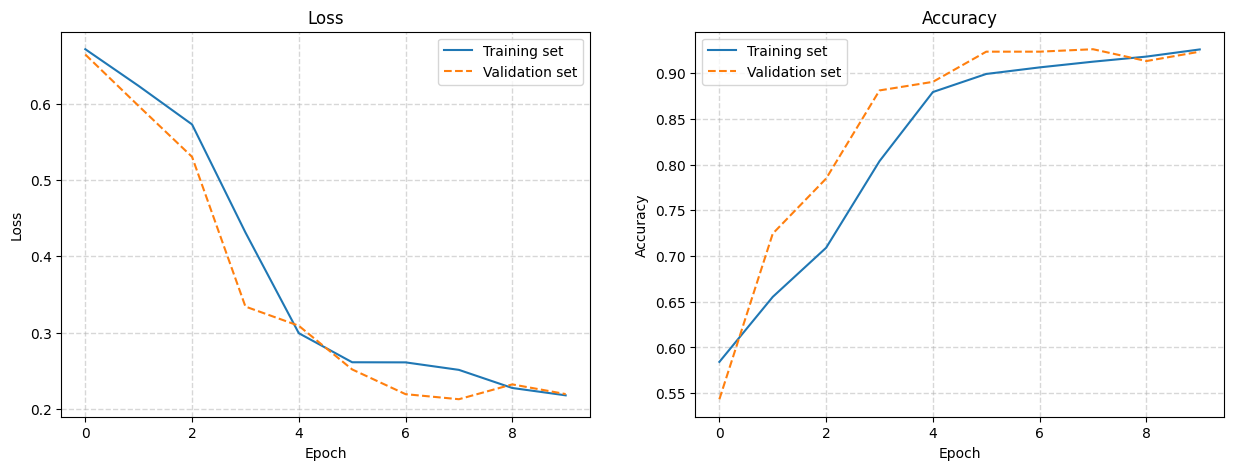

In [52]:
loss = result.history['loss']
val_loss = result.history['val_loss']
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

In [59]:
print(train_generator.class_indices)

{'chicken': 0, 'dog': 1, 'spider': 2}


## Testing

Saving chicken (1).jpeg to chicken (1) (3).jpeg
1/1 [==============================] - 0s 22ms/step
chicken (1).jpeg
Chicken


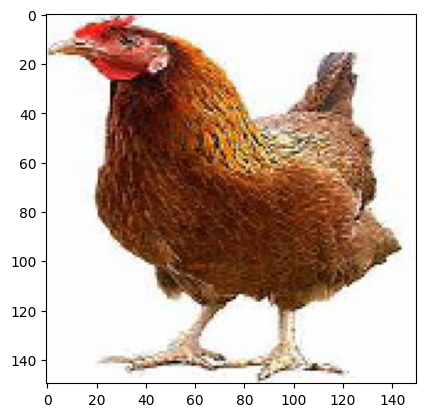

In [64]:
uploaded = files.upload()

# Predicting images
for up in uploaded.keys():
    path = up
    img  = image.load_img(path, target_size = (150, 150))

    imgplot = plt.imshow(img)
    x       = image.img_to_array(img)
    x       = np.expand_dims(x, axis = 0)

    images  = np.vstack([x])
    classes = model.predict(images, batch_size = 10)
    print(up)

    predicted_class = np.argmax(classes)

    if predicted_class == 0:
      print('Chicken')
    elif predicted_class == 1:
      print('Dog')
    elif predicted_class == 2:
      print('Spider')
    else:
      print('Unclassified')

## **Convert to TFLite**

In [53]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [55]:
with tf.io.gfile.GFile('model__v1.tflite', 'wb') as f:
  f.write(tflite_model)